# Reading of input values for the further analysis
Parses the csv files containing the aquired data of the analyses

In [1]:
#!/usr/bin/env python3

import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from statsmodels.nonparametric.kernel_density import KDEMultivariate
import statsmodels.api as sm
import itertools
from sklearn.metrics import cohen_kappa_score


class Read_BCS():
    def __init__(self, ext_path=None):
        self.path = "../BCS-Evaluierung/Results/"
        if ext_path is not None:
            self.path = self.path + ext_path

    def read_res(self, r_file):
        for f in r_file:
            p = self.path + f
            if "BCS" in f or "RFD" in f or "App" in f:
                t = pd.read_csv(p, sep=";", header=0, index_col=0)
                yield t
            elif "Final Results" in self.path:
                try:
                    t = pd.read_csv(p, sep=";", header=2, index_col=[0, 1])
                except IndexError:
                    t = pd.read_csv(p, sep="\t", header=2, index_col=[0, 1])
                    # this case catches errors in the formatting of libreoffice
                    # csv files, which might be tabulator separated
                yield [t, f]

    def file_path(self, n, tr=True):
        fs = os.listdir(self.path)
        r_file = [
            v for v in fs if n in v 
            and ".png" not in v 
            and ".pdf" not in v 
            and ".~lock" not in v
            and not os.path.isdir(self.path + v)
        ]
        for t in self.read_res(r_file):
            if tr is True:
                t = t.T
                # transposes the matrix
                t.dropna(inplace=True, how="all")
                # no for loop necessary to remove empty 
                # cells
            
                yield t
            else:
                yield t



# Plotting
Distribution plotting of the BCS and RFD scores determined in the Cowdition app and in the MobileScan application

In [4]:
class Eval_BCS():
    def __init__(self, n):
        self.read_bcs = Read_BCS(n)
    
    def data_orgs(self, n="App-Results", v="Aktueller BCS"):
        # v → the column, which is needed from the csv file
        for t in self.read_bcs.file_path(n):
            v = t.loc[v]
            # selects the required values from the dataframe 
            # and returns a series with all checked cows
            v.dropna(inplace=True)
            # especially important when dealing with the RFD data
            # to drop empty cells
            v = v.apply(
                lambda x: np.float64(x.replace(",", "."))
            )
            if "App-Results" in n:
                data = self.app_bcs_sorting(v)
            if "RFD" in n:
                data = self.rfd_sorting(v)
            
        return data
    
    def hist_plotting(self, n="App-Results", v="Aktueller BCS"):
        data = self.data_orgs(n, v)
        fig, ax = plt.subplots(
            1, 
            figsize=(8, 6), 
            sharex="all", 
            sharey="all"
        )
        _ax = ax.twinx()
        for farm_data in data:
            ax.hist(
                farm_data.values, 
                bins=int(np.sum(np.arange(1, 5, 0.25))), 
                label=farm_data.name
            )
            kde = KDEMultivariate(
                farm_data.values,
                var_type='c'
            )
            # bandwidth of the KDEMultivariate has to remain empty, 
            # as otherwise the calculation is bound to fail
            pdf = kde.pdf(
                    np.linspace(1, 5, num=1000)
            )
            # this is the proof the kernel density function works also for 
            # a continuous set of numbers in the range of the BCS values
            _ax.plot(
                np.linspace(1, 5, 1000), 
                pdf, 
                label=farm_data.name
            )
            # the length of the range dataset has to be similar among both the 
            # probability density function calculation and the consecutive plotting
        plt.xlabel("BCS values")
        ax.set_ylabel("Amount of cows")
        _ax.set_ylabel("Probability of occurence of values")
        plt.title("Distribution between the different BCS values")
        plt.grid()
        ax.legend()
        _ax.legend()
        #fig.tight_layout()
        plt.show()
        fig.savefig(Read_BCS().path + n + " Histogramm.png", dpi=fig.dpi)
        # please refer to 
        # https://stackoverflow.com/questions/7906365/matplotlib-savefig-plots-different-from-show
        # for the explanation
    
    def app_bcs_sorting(self, data):
        hf_dfh = pd.Series(
            name="Frankenhausen Holstein-Friesian",
            dtype=np.float
        )
        # contains the data from Frankenhausen under the Holstein-Friesian assumption
        fl_dfh = pd.Series(
            name="Frankenhausen Simmental",
            dtype=np.float
        )
        # contains the data from Frankenhausen under the Simmental assumption 
        hf_die = pd.Series(
            name="Füllgrabe",
            dtype=np.float
        )
        # contains the data from Diemarden
        for l in data.index:
            try:
                l_index = np.int8(l)
                # as only the Diemarden data have a numerical index, these data 
                # can be separated in the exception
                hf_die.loc[l_index] = data.loc[l]
            except ValueError:
                if "HF" in l:
                    hf_dfh.loc[l] = data.loc[l]
                elif "FL" in l:
                    fl_dfh.loc[l] = data.loc[l]
        return [hf_dfh, fl_dfh, hf_die]
    
    def cohens_kappa_app(self, n="App-Results", v="Aktueller BCS"):
        data = self.data_orgs(n, v)
        l = []
        # the list contains the two array, which include the data on 
        # the different cows
        n = []
        for farm_data in data:
            if "Frankenhausen" in farm_data.name:
                l.append(farm_data)
                n.append(farm_data.name)
                # as there are only two arrays present in the list, the 
                # processing of the data involved is simplified
        dist = pd.DataFrame(
            index=np.arange(0, 5 + 0.25, 0.25), 
            data=np.zeros(np.int(5 / 0.25) * 2 + 2).reshape(np.int(5/0.25) + 1, 2), 
            columns=n
        )
        for ds in l:
            for _ind in ds.index:
                v = ds.loc[_ind]
                dist.loc[v, ds.name] += 1
        # both arrays must have the same length, as the Simmental array is shorter than the 
        # Holstein-Friesian array, the Holstein-Friesian array length has to be adapted
        ck = cohen_kappa_score(
            dist[n[0]],
            dist[n[1]],
            labels=None, 
            weights=None
        )
        return ck

#Eval_BCS(None).hist_plotting("App-Results", "Aktueller BCS")
#Eval_BCS().hist_plotting("RFD", "RFD")
Eval_BCS(None).cohens_kappa_app()

/home/thomas/Programmieren/Analyses/lib64/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/home/thomas/Programmieren/Analyses/lib64/python3.6/site-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/home/thomas/Programmieren/Analyses/lib64/python3.6/site-packages/ipykernel_launcher.py:81: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


0.4970059880239521

# Final Result Processing

This class processes the final results, which were gathered in designated csv files and can now be compared between both different sampling methods and different farms.

/home/thomas/Programmieren/Analyses/lib64/python3.6/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


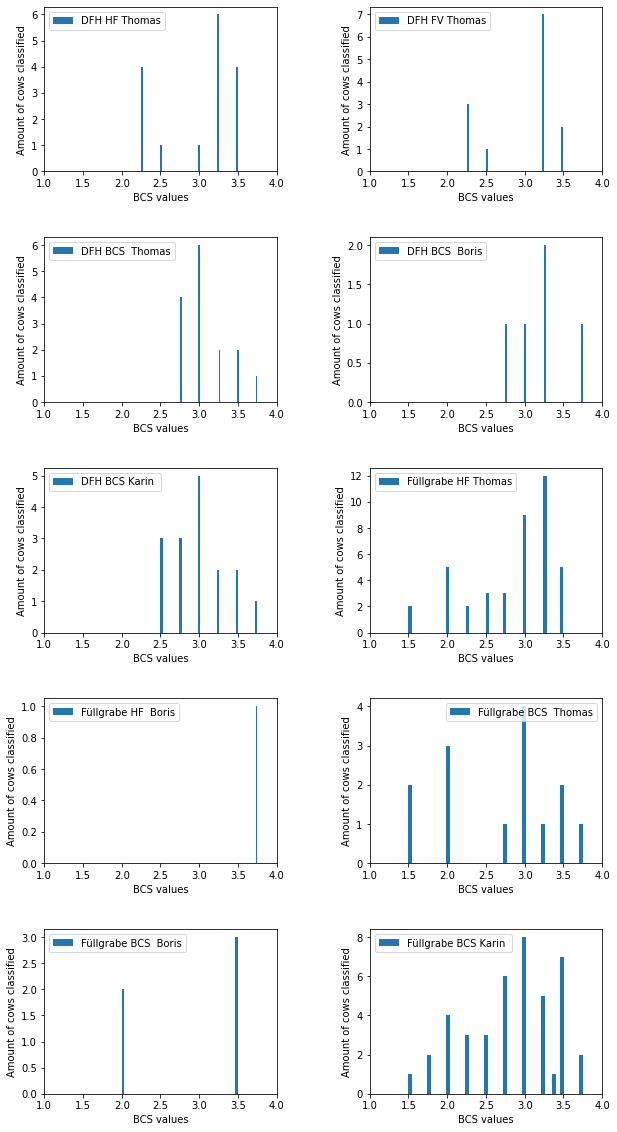

Farm              DFH                                             Füllgrabe  \
Measurement HF Thomas FV Thomas BCS  Thomas BCS  Boris BCS Karin  HF Thomas   
cow                                                                           
5                 NaN       NaN         NaN        NaN        NaN      3.00   
287              2.25      2.25        2.75        NaN       2.75       NaN   
9                 NaN       NaN         NaN        NaN        NaN      2.00   
342              3.25      3.25        3.00       3.25       3.25       NaN   
14                NaN       NaN         NaN        NaN        NaN      3.00   
378              3.25      3.25        3.00       3.25       2.75       NaN   
15                NaN       NaN         NaN        NaN        NaN      2.00   
425              3.00      3.25        2.75        NaN       2.75       NaN   
20                NaN       NaN         NaN        NaN        NaN      3.25   
429              3.25      3.25        3.00       3.00       3.00       NaN   
24                NaN       NaN         NaN        NaN        NaN      3.00   
452              2.25      2.25        2.75       2.75       2.50       NaN   
26                NaN       NaN         NaN        NaN        NaN      3.50   
481              2.25      2.25         NaN        NaN       2.50       NaN   
27                NaN       NaN         NaN        NaN        NaN      3.50   
501              2.50      3.25        3.00        NaN       3.00       NaN   
28                NaN       NaN         NaN        NaN        NaN      2.50   
503              3.50      3.50        3.50        NaN       3.50       NaN   
29                NaN       NaN         NaN        NaN        NaN      2.75   
511              3.50      3.50        3.75       3.75       3.75       NaN   
30                NaN       NaN         NaN        NaN        NaN      1.50   
514              2.25      2.50        2.75        NaN       2.50       NaN   
33                NaN       NaN         NaN        NaN        NaN      2.25   
534              3.25      3.25        3.25        NaN       3.25       NaN   
33                NaN       NaN         NaN        NaN        NaN      2.25   
536              3.50       NaN        3.50        NaN       3.50       NaN   
35                NaN       NaN         NaN        NaN        NaN      2.50   
538              3.25      3.25        3.00        NaN       3.00       NaN   
40                NaN       NaN         NaN        NaN        NaN      1.50   
541              3.50       NaN        3.25        NaN       3.00       NaN   
45                NaN       NaN         NaN        NaN        NaN      3.00   
550              3.25       NaN        3.00        NaN       3.00       NaN   
47                NaN       NaN         NaN        NaN        NaN      3.00   
55                NaN       NaN         NaN        NaN        NaN      3.50   
58                NaN       NaN         NaN        NaN        NaN      3.25   
59                NaN       NaN         NaN        NaN        NaN      3.25   
60                NaN       NaN         NaN        NaN        NaN      2.00   
64                NaN       NaN         NaN        NaN        NaN      3.25   
65                NaN       NaN         NaN        NaN        NaN      3.00   
68                NaN       NaN         NaN        NaN        NaN      3.00   
73                NaN       NaN         NaN        NaN        NaN      2.00   
77                NaN       NaN         NaN        NaN        NaN      3.50   
79                NaN       NaN         NaN        NaN        NaN      3.25   
79                NaN       NaN         NaN        NaN        NaN       NaN   
80                NaN       NaN         NaN        NaN        NaN      3.25   
84                NaN       NaN         NaN        NaN        NaN      2.00   
85                NaN       NaN         NaN        NaN        NaN      3.25   
88                NaN       NaN         NaN       

In [2]:
class All_Results():
    def __init__(self, n="Final Results/"):
        self.read_bcs = Read_BCS(n)
    
    def data(self):
        for d in self.read_bcs.file_path("Results", tr=False):
            t = d[0]
            f = d[1]
            t.columns = np.array([f.replace("\n", " ") for f in t.columns])
            # replaces the line breaks in the columns with empty spaces
            t["Geb. Dat."] = pd.to_datetime(t["Geb. Dat."], dayfirst=True)
            t["letztes Kalb"] = pd.to_datetime(t["letztes Kalb"], dayfirst=True)
            yield [t, f]
            
    def clear_data(self):
        df = pd.DataFrame()
        for d in self.data():
            t = d[0]
            _t = pd.DataFrame()
            for c in t.columns:
                _c = t[c].dropna()
                try:
                    _cr = _c.apply(
                        lambda x: np.float64(x.replace(",", "."))
                    )
                    _t = pd.concat([_t, _cr], axis=1)
                except ValueError:
                    _t = pd.concat([_t, _c], axis=1)
                    continue
                except AttributeError:
                    _t = pd.concat([_t, _c], axis=1)
                    continue
            n = list(itertools.repeat(d[1].split(" ")[1], len(_t.columns)))
            _t.columns = pd.MultiIndex.from_arrays([n, _t.columns], names=["Farm", "Columns"])
            df = pd.concat([df, _t], axis=1)
        return df
    
    def dist_plots(self, plot=True):
        _in = self.clear_data()
        bcs = pd.DataFrame()
        if plot is True:
            fig = plt.figure(figsize=(10, 20))
            fig.subplots_adjust(hspace=0.4, wspace=0.4)
            i = 1
        for farm in np.unique(_in.columns.get_level_values("Farm")):
            for c in _in[farm].columns:
                if "BCS" in c and "RFD" not in c or "HF" in c or "FV" in c:
                    v = _in.loc[:,(farm, c)].dropna(how="all")
                    if plot is True:
                        ax = fig.add_subplot(5, 2, i)
                        n = v.name[0] + " " +  v.name[1]
                        ax.hist(
                            v.values, 
                            np.int(np.sum(np.arange(1, 5, 0.25))), 
                            label=n
                        )
                        # please refer the subplots design to:
                        # https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html
                        ax.set_xlim(1, 4)
                        i += 1
                        ax.legend()
                        ax.set_xlabel("BCS values")
                        ax.set_ylabel("Amount of cows classified")
                    bcs = pd.concat([bcs, v], axis=1)
        bcs.columns = pd.MultiIndex.from_tuples(bcs.columns, names=["Farm", "Measurement"])
        bcs.index = pd.MultiIndex.from_tuples(bcs.index, names=["index no", "cow"])
        bcs.reset_index(inplace=True, drop=False)
        bcs.index = bcs["cow"]
        bcs.drop(["cow", "index no"], axis=1, inplace=True)
        if plot is True:
            plt.show()
        return bcs
    
    def data_preprocessing(self, weights=False):
        _in = self.dist_plots(plot=False)
        raters = pd.DataFrame()
        cows = pd.DataFrame()
        if weights is True:
            cow_weight_data = pd.DataFrame()
            rater_weight_data = pd.DataFrame()
        for farm in np.unique(_in.columns.get_level_values("Farm")):
            fdata = _in[farm].dropna(how="all")
            fdata = fdata.groupby(level=0).mean()
            # This solution is a modified solution posted on stackoverflow:
            # https://stackoverflow.com/questions/35855772/pandas-merge-duplicate-index-into-single-index/35855847#35855847
            #fdata.index = pd.MultiIndex.from_tuples(fdata.index, names=["index no.", "cow"])
            famount = pd.DataFrame()
            # DataFrame for the comparison of raters between each other
            camount = pd.DataFrame()
            # DataFrame for the comparison of individual cow's scoring by 
            # different raters
            for r in np.unique(fdata.columns):
                # this step counts the amounts, raters gave certain ratings to cows
                # Therefore, the loop iterates over each cow and rating
                rd = fdata[r].dropna(how="all")
                # these are the individual data for each rater, the cows are in the index
                cs = self.kappa_array(rd)
                # cs checks the qualitative question, how much the rater complies 
                # with the estimated true value for all cows
                cs.name = " ".join(cs.name.split())
                famount = pd.concat([famount, cs], axis=1)
            famount.columns = pd.MultiIndex.from_arrays(
                [list(itertools.repeat(farm, len(famount.columns))), famount.columns],
                names=["Farm", "Raters"]
            )
            raters = pd.concat([raters, famount], axis=1)
            for c in np.unique(fdata.index):
                # this is now the loop to iterate the cows and compare the raters in the scoring, they 
                # gave for each particular cow
                cd = fdata.loc[c,:].dropna(how="all")
                cow_amounts = self.kappa_array(cd)
                # cow_amounts is the DataFrame to the question, how much raters 
                # differ in the evaluation of each cow
                camount = pd.concat([camount, cow_amounts], axis=1)
            #camount.columns = [i[1] for i in camount.columns]
            camount.columns = pd.MultiIndex.from_arrays(
                [
                    list(
                        itertools.repeat(
                            farm, len(camount.columns)
                        )
                    ), 
                    camount.columns
                ], 
                names=[
                    "Farm", 
                    "Cows"
                    ]
            )
            cows = pd.concat([cows, camount], axis=1)
            if weights is True:
                cow_real = fdata.mean(axis=1)
                # the mean of all raters' BCS scoring is considered an estimator to the true value
                # of the cow's BCS
                cow_weights = pd.DataFrame()
                # cow_weighed is the weights DataFrame to the question, how much raters 
                # differ in the evaluation of each cow
                for cow in np.unique(fdata.index):
                    cseries = fdata.loc[cow,:].dropna(how="all")
                    cow_weighed = self.quadratic_weight(cseries, cow_real.loc[cow])
                    cow_weights = pd.concat([cow_weights, cow_weighed], axis=1, sort=False)
                cow_weights.columns = pd.MultiIndex.from_arrays(
                    [list(itertools.repeat(farm, len(cow_weights.columns))), cow_weights.columns],
                    names=[
                        "Farm", 
                        "Raters"
                    ]
                )
                cow_weight_data = pd.concat([cow_weight_data, cow_weights], axis=1, sort=False)
                rater_real = famount.mean(axis=1)
                # this is the estimator for the true value, how often the raters should have 
                # given a certain BCS value during the trial
                farm_rater = pd.DataFrame()
                for rater in np.unique(famount.columns.get_level_values("Raters")):
                    rv = famount.loc[:,pd.IndexSlice[farm, rater]].dropna(how="all")
                    # since this is a series derived from a dataframe for counting values, these values rarely ever become
                    # NaN
                    v = self.quadratic_weight(rv, rater_real)
                    farm_rater = pd.concat([farm_rater, v], axis=1)
                farm_rater.columns = pd.MultiIndex.from_tuples(
                    farm_rater.columns, 
                    names=["Farm", "Raters"]
                )
                rater_weight_data = pd.concat([rater_weight_data, farm_rater], axis=1, sort=False)
        if weights is True:
            return [raters, cows, cow_weight_data, rater_weight_data]
        else:
            return [raters, cows]
    
    def kappa_array(self, df):
        evs = pd.Series(
            data=np.zeros(np.int(5/0.25) + 1), 
            # this sets the 0 case for the matrix
            name=df.name, 
            index=np.arange(0, 5 + 0.25, 0.25),
            # these are the BCS values, which can be obtained in classic scoring
            dtype=np.float
        )
        df.dropna(inplace=True, how="all")
        for i in np.unique(df.index):
            v = np.float(df.loc[i])
            if v in evs.index:
                evs.loc[v] += 1
        return evs
        
    def quadratic_weight(self, data, real):
        r = pd.Series(index=data.index, name=data.name, dtype=np.float)
        for i in data.index:
            if type(real) == pd.core.series.Series:
                r.loc[i] = 1 - (np.square(data.loc[i] - real.loc[i])/np.square(len(data.index) - 1))
                # This is the squared difference between the truth estimator and the 
                # individual value. As it is calculated for each cow, it therefore includes the deviation 
                # in the raters scoring from the estimated true value.
                # The weights are calculated in a series, which includes the deviation from the 
                # estimated true value. Please refer the calculation and explanation to:
                # http://www.real-statistics.com/reliability/weighted-cohens-kappa/ and 
                # https://stats.stackexchange.com/a/206438
            else:
                r.loc[i] = 1 - (np.square(data.loc[i] - real))/np.square(len(data.index) - 1)
        return r
    
    def cohens_kappa_all(self, weights=False):
        _in = self.data_preprocessing(weights)
        if weights is True:
            cow_weight_data = _in[2]
            rater_weight_data = _in[3]
            rater_weight_data.columns = pd.MultiIndex.from_tuples(rater_weight_data.columns, names=["Farm", "Raters"])
            raters = _in[0]
            cows = _in[1]
        else:
            raters = _in[0]
            cows = _in[1]
        rater_results = pd.DataFrame(index=raters.columns, columns=raters.columns)
        for f in np.unique(raters.columns.get_level_values("Farm")):
            # this loop draws the comparison arrays from the 
            # dataframe
            rater_data = raters[f].dropna(how="all")
            cow_data = cows[f].dropna(how="all")
            for ev in np.unique(rater_data.columns):
                rater_ev_data = rater_data[ev].dropna(how="all")
                # this loop draws all rater columns from the dataframe
                for comp in np.unique(rater_data.columns):
                    rater_compd = rater_data[comp].dropna(how="all")
                    # this loop again draws all columns from the dataframe, allowing to 
                    # compare each column agains each other column for the raters
                    try:
                        if weights is False:
                            rater_results.loc[pd.IndexSlice[f, comp], pd.IndexSlice[f, ev]] = cohen_kappa_score(
                                rater_ev_data, 
                                rater_compd, 
                                weights=None, 
                                labels=None
                            )
                        else:
                            raters_weight = rater_weight_data.loc[:,pd.IndexSlice[f,ev]]
                            rater_results.loc[pd.IndexSlice[f, comp], pd.IndexSlice[f, ev]] = cohen_kappa_score(
                                rater_ev_data, 
                                rater_compd, 
                                weights="quadratic", 
                                labels=None,
                                sample_weight=raters_weight
                            )
                    except ValueError:
                        rater_results.loc[pd.IndexSlice[f, comp], pd.IndexSlice[f, ev]] = "Exception"
        return rater_results
    
    def kappa_dist(self):
        _in = self.cohens_kappa_all()
        fig = plt.figure(figsize=(8, 10))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)
        i = 1
        for farm in np.unique(_in.columns.get_level_values("Farm")):
            ax = fig.add_subplot(2, 1, i)
            ax.hist(_in.loc[(farm), (farm)], bins=40)
            i += 1

#All_Results().data_preprocessing(weights=True)
#All_Results().cohens_kappa_all(weights=True)
All_Results().dist_plots()#.loc[:,"DFH"].dropna(how="all")

In [ ]:
cows_results = pd.DataFrame(index=cows.columns, columns=cows.columns)
for cow_ev in np.unique(cow_data.columns):
    cow_ev_data = cow_data[cow_ev].dropna(how="all")
    for comp_cow in np.unique(cow_data.columns):
        cow_comp = cow_data[comp_cow].dropna(how="all")
        if weights is False:
            cows_results.loc[(f, cow_ev), (f, comp_cow)] = cohen_kappa_score(
                cow_ev_data, 
                cow_comp, 
                weights=None, 
                labels=None
            )
        else:
            #cow_ev_data.replace(0, np.NaN, inplace=True)
            #cow_ev_data.dropna(inplace=True, how="all")

            #cow_comp.replace(0,np.NaN, inplace=True)
            #cow_comp.dropna(inplace=True, how="all")
            # these two steps eliminate values not scored for this particular cow, 
            # as these values do not need to be represented in the following calculation

            cow_weight = cow_weight_data.loc[:,(f, cow_ev)].replace(np.NaN, 0)
            print(cow_ev_data, cow_comp, cow_weight)
            cows_results.loc[(f, cow_ev), (f, comp_cow)] = cohen_kappa_score(
                cow_ev_data, 
                cow_comp, 
                weights="quadratic",
                labels=None,
                sample_weight=cow_weight
            )